<a href="https://colab.research.google.com/github/fellowship/-fitness-activity-recognition/blob/main/Blazepose_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import stats

Connecting the google drive folders 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Selecting the desired mediapipe version

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

## Helper Function

In [ ]:
# Configs
config = {
    "train_test_split":0.25,
    "random_state":4
}

mark_false improves performance of the pose estimation by marking the image as not writeable to pass by reference

In [ ]:
def mark_false(image, pose):
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    return results

## Extracting 3D coordinates

In [ ]:
# reading csv file for the current blazepose_coordinates 
data = pd.read_csv("drive/MyDrive/Fellowship.AI/blazepose_coordinates_main.csv", index_col = 0)

## Data Preprocessing

In [ ]:
# reading csv file for the current blazepose_coordinates 
data = pd.read_csv("drive/MyDrive/Fellowship.AI/blazepose_coordinates_main.csv", index_col = 0)

In [ ]:
#### NEW CLASSES HERE ####

# Excersices can be broadly categorized as: https://www.livestrong.com/article/534321-five-types-of-fitness-training/
## High intensity/speed
aerobic = ['jump_rope','jumping_jacks','dancing','jumping', 'x_jumps', 'running', 'all_fours_warm_up',
  'skii_hops','squat_jumps', 'lateral_squad_jumps','lateral_squat_jumps','lateral_shuffle','walking']

coordination_agility = ['agility_feet', 'run_in_place','standing_skips','high_knees', 
  'mountain_climbers','mountain_climber','boxing','high_knee_sprints','high_knee_sprint', 
  'burpy_crawl_combo','burpy', 'pace_skips', 'criss_cross','cross_crunches','surfer_hops',
  'split_hop','lower_knee_hop','torso_up_double_leg_extension'] # Could also fit in as a subclass of aerobic activities
# Could maybe also fit in with calisthenics?: 'burpy_crawl_combo','burpy'

## NOTE: Uncomment if combining coordination_agility with aerobic
# [aerobic.append(item) for item in coordination_agility]

## Medium intensity/speed and lifting 
# each below are subtypes of strength training (can use uniquely or put under strength training)
weight_bearing = ['bodyweight_squats','lateral_lunges','lunges','squats','body_weight_squats',
  'lateral_squat_walk_reverse_lundge','squat_hold_reverse_lundge','lateral_squat_walk_reverse_lundge',
  'body_weight_squat_toes','drop_squats']

# non_wieght_bearing = ['torso_up_double_leg_extension', 'hamstring_curl_right','hamstring_curl_left'] # (aka prone strength training)

calisthenics = ['knees_to_elbow', 'loaded_beast_push_up','modified_push_ups','crunches','pushups',
   'pullups','wall_pushups','pulse_ups_right','pulse_ups_left','straight_left_leg_pulse'] # (bodyweight excersizes)

weightlifting = ['bench_press','triceps','donkey_press','front_press','front_up_pulse']

## NOTE: Uncomment below if combining above classes into single strength training class
# comb_list =[weight_bearing, non_wieght_bearing, calisthenics, weightlifting]
# strength_training = [item for sublist in comb_list for item in sublist] # flat strength training list if single class preferred.

##### Lower intensity/speed (flexibility, stability) ######
balance_stability = ['bear_hold_knee_taps','bear_hold_shoulder_taps','bear_hold',
  'fullbody_walkouts', 'lay_down_knees_up', 'lay_down_one_knee_up','lay_down_knee_up_down',
  'lay_down_knee_swing_shoulder_blades_up','fire_hydrants','roll_up','alternating_deadbug',
  'single_bent_leg_lower','double_bent_leg_lower', 'double_leg_extension', 'upper_body_up_criss_cross',
  'bear_hold_taps','bear_crawl','forward_plank','left_side_plank','right_side_plank','arm_plank',
  'modified_arm_plank','left_side_plank_reaching','right_side_plank_reaching','kickbacks_right_glute',
  'straight_right_leg_pulse','kickbacks_left_glute','hip_bridge','forearm_plank','high_plank',
  'high_plank_right_leg_press','push_hip_up_right_leg','push_hip_up_left_leg','high_plank_shoulder_feet_combo',
  'straight_leg_lifts','push_hip_up_right_leg_up','hip_up_right_swing_down','push_hip_up_left_leg_up','hip_up_left_swing_down',
  'high_plank_left_leg_press','reverse_dog_crunch', 'all_fours_drive','forearm_plank_rocking','upper_body_up_double_leg_extension',
  'front_laying_leg_lifts','front_laying_arms_legs_lifts','plank_dynamic','plank_static','side_plank_dynamic','plank', 'hamstring_curl_right','hamstring_curl_left']
# Could fit in elsewhere also (calisthenics): alternating_deadbug, fire_hydrants, kickbacks_right_glute, 

flexibility = ['yoga,stretching','streching','yoga,','yoga,ground','yoga,all_four','yoga,standing'
  'strech','stretching', 'down_dog','up_dog','runners_lundge_reach','table_top','all_fours',
   'knees_to_chest','cat_cow','all_fours_elbow_spine_stretch','up_down_dog']
# Could be further split into dynamic and static stretches

idle = ['idle','all_fours_idle','standing','standing,talking','talking,walking','talking','standing_idle','standing_writing','walking_idle','kneeling_idle','table_top_position_idle','sitting','sitting_idle' 'laying_flat','laying_down_idle','laydown_faceup','laying_down_face_up','front_laying_position','laying_down_flat','laydown_face_up','laydown_flat','front_laying_idle', 'hanging']
doubt = ['transition','glutes','shuffle_position', 'adjusting','pointing']
remove = ['slides', 'off_screen', 'slide', 'pointing', 'offscreen','intro_page']

In [ ]:
def change_actions(x):
    if x in aerobic:
        return 'aerobic'
    elif x in coordination_agility:
        return 'coordination_agility'
    elif x in weight_bearing:
        return 'weight_bearing'
    elif x in calisthenics:
        return 'calisthenics'
    elif x in weightlifting:
        return 'weightlifting'
    elif x in balance_stability:
        return 'balance_stability'
    elif x in flexibility:
        return 'flexibility'
    elif x in remove:
        return 'remove'
    elif x in doubt:
        return "doubt"
    else:
        return 'idle'

In [ ]:
req = annotated.iloc[:,3:].values.tolist()
flatten = [items for lists in req for items in lists]
flatten = [x for x in flatten if str(x) != 'nan']
count_dict={}
for action in flatten:
    if action in count_dict:
        count_dict[action]+=1
    else:
        count_dict[action]=1

count =pd.DataFrame.from_dict(count_dict,orient = 'index')
count.reset_index(inplace=True)
count = count.rename(columns = {'index':'actions'})

count['six_class' ]= count['actions'].apply(lambda x: change_actions(x))

In [ ]:
data['target']= data['actions'].apply(lambda x: change_actions(x))
data.drop(['actions'] , axis = 1,inplace = True)
data.head()

,video_id,frame_count,fps,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,target
0,473.0,1.0,29.0,0.352177,0.398236,-0.289880,0.350398,0.368885,-0.306512,0.353546,...,0.802038,0.561437,0.472156,0.824346,0.664165,0.264521,0.792377,0.646016,0.446963,calisthenics
1,473.0,2.0,29.0,0.350715,0.403618,-0.283021,0.348484,0.374674,-0.298983,0.351593,...,0.794172,0.557257,0.468444,0.814389,0.655966,0.287102,0.784114,0.639265,0.454606,calisthenics
2,473.0,3.0,29.0,0.349499,0.411555,-0.286922,0.346597,0.381458,-0.303021,0.349692,...,0.794630,0.557192,0.481575,0.813795,0.653142,0.308689,0.783757,0.639580,0.479100,calisthenics
3,473.0,4.0,29.0,0.346089,0.416364,-0.303344,0.343975,0.386571,-0.318925,0.347301,...,0.794825,0.556308,0.482358,0.814680,0.649590,0.310909,0.784460,0.638047,0.477242,calisthenics
4,473.0,5.0,29.0,0.342475,0.423968,-0.327087,0.341991,0.393442,-0.342491,0.345512,...,0.795100,0.556158,0.498173,0.813112,0.650373,0.326784,0.783645,0.639078,0.495790,calisthenics


## Feature Engineering

In [ ]:
# Function to return the diffrence in coordinate of xth frame and x+nth frame
def data_transform(data, n, step, test =False):  
    if test == False:
        segments = []
        labels = []
        video_id = []
        for id in data['video_id'].unique():
            sub_set = data[data["video_id"] == id]
            for i in range(0, sub_set.shape[0] - n, step):
                values = ((sub_set.iloc[i+n, 3:102] - sub_set.iloc[i, 3:102]) / sub_set.iloc[i+n, 3:102])
                label = stats.mode(sub_set['target'][i: i+n])[0][0]
                segments.append([values.append(sub_set.iloc[i+n, 3:102])])
                labels.append(label)
        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,198)
        df = pd.DataFrame(reshaped_segments)
        df['target'] = labels       
        return(df)       
    else:
        segments = []
        data = pd.DataFrame(points) 
        for i in range(0, data.shape[0] - n, step):
            values = ((data.iloc[i+n, :] - data.iloc[i, :]) / data.iloc[i+n, :])
            segments.append([values.append(data.iloc[i+n, :])])
        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,198)
        return(reshaped_segments)
  

In [ ]:
data.groupby("target").size()

target
aerobic                 22956
balance_stability       93733
calisthenics            51935
coordination_agility    53456
doubt                     479
flexibility             70721
idle                    51335
weight_bearing          40893
weightlifting           10996
dtype: int64

In [ ]:
data_transformed = data_transform(data, 5,5)

remove_from_target = ['doubt', 'remove']

data_transformed = data_transformed[~data_transformed['target'].isin(remove_from_target)]

print(data_transformed.groupby("target").size())

X = data_transformed.iloc[:,:-1]
y =data_transformed['target']

target
aerobic                  4518
balance_stability       18703
calisthenics            10143
coordination_agility    10560
flexibility             14110
idle                    10248
weight_bearing           8074
weightlifting            2143
dtype: int64


In [ ]:
# changing the target value to numeric value to fit the data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=config["train_test_split"], random_state=config["random_state"], shuffle  = True)

In [ ]:
# Helper function to calculate metrics and visualize data

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score,roc_auc_score, accuracy_score, log_loss

def metrics(model, X_train, y_train, X_test, y_test, cf_matrix = False):
    
    # Create a classifier
    

    # Use trained model to predict output of test dataset
    log_metric = 0
    predictions  = model.predict(X_test) 
    try:
      preds_probs = model.predict_proba(X_test)
      loss_metric =  log_loss(y_test, preds_probs)
    except:
      print("Model doesn't supports probability calculation")
    
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    f1 = f1_score(y_test, predictions, average='macro')
    precision = precision_score(y_test, predictions,average = 'micro', pos_label=1)
    recall = recall_score(y_test, predictions,average = 'micro', pos_label=1)
   
    print("ACCURACY PER INSTANCE:" ,accuracy)
    print("F1_score:" ,f1)
    print("Precision:", precision)
    print("Recall:",recall)
    if (loss_metric):
      print("Log Loss", loss_metric)
    (unique,count) = np.unique(le.inverse_transform(y_train),return_counts=True)
    class_labels = unique


    # plotting confusion matrix
    
    if cf_matrix == True:

        plt.figure(figsize = (16,6))
        sns.heatmap(pd.DataFrame(confusion_matrix(y_test , predictions)),annot=True, fmt="d",
                    xticklabels = class_labels, yticklabels = class_labels)

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        print(classification_report(y_test, predictions,target_names=class_labels))
        plt.show()

## XGBoost

In [ ]:
# XG Boost Classifier

from xgboost import XGBClassifier
xgb = XGBClassifier(objective=  'multi:softproba' , max_depth=15, random_state =config["random_state"] )
# Fit the classifier with the training data
xgb.fit(X_train,y_train)

XGBClassifier(max_depth=15, objective='multi:softprob', random_state=4)

ACCURACY PER INSTANCE: 0.9628535031847134
F1_score: 0.9592569062621825
Precision: 0.9628535031847134
Recall: 0.9628535031847134
                      precision    recall  f1-score   support

             aerobic       0.97      0.94      0.95      1129
   balance_stability       0.97      0.99      0.98      4676
        calisthenics       0.98      0.97      0.97      2536
coordination_agility       0.95      0.95      0.95      2640
         flexibility       0.98      0.97      0.97      3528
                idle       0.93      0.93      0.93      2562
      weight_bearing       0.97      0.96      0.96      2018
       weightlifting       0.97      0.94      0.95       536

            accuracy                           0.96     19625
           macro avg       0.96      0.96      0.96     19625
        weighted avg       0.96      0.96      0.96     19625



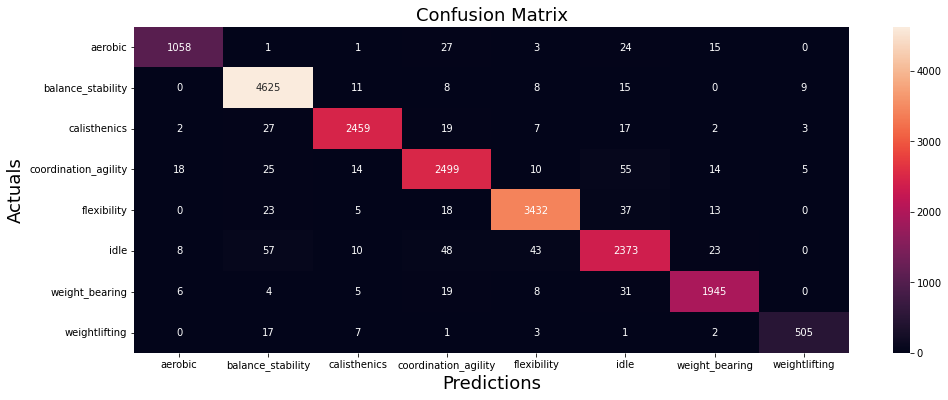

(array([4, 4, 4, ..., 0, 4, 3]),
 array([[1.2679136e-04, 1.1294752e-03, 2.8232936e-04, ..., 2.6859657e-04,
         1.7397357e-04, 2.4080813e-04],
        [6.0679944e-05, 3.6562647e-05, 2.1996269e-04, ..., 9.3651273e-05,
         1.5082676e-04, 3.9996914e-05],
        [5.5870053e-04, 5.3567059e-05, 8.4813865e-04, ..., 2.0703065e-04,
         7.4327952e-04, 4.9026403e-05],
        ...,
        [5.4842657e-01, 3.6527230e-03, 2.1766888e-02, ..., 3.2271121e-02,
         1.3310929e-02, 1.1851862e-02],
        [3.9582483e-05, 1.9588371e-04, 8.8952198e-05, ..., 1.4398739e-04,
         5.7101774e-05, 5.6384491e-05],
        [2.1281827e-02, 5.2222941e-04, 7.6727504e-03, ..., 1.3816096e-03,
         2.0064204e-03, 1.4749976e-03]], dtype=float32),
 0.9628535031847134,
 0.9592569062621825,
 0.9628535031847134,
 0.9628535031847134,
 <function sklearn.metrics._classification.log_loss>)

In [ ]:
metrics(xgb,X_train, y_train, X_test, y_test,cf_matrix=True)

### ExtraTrees



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf_extra = ExtraTreesClassifier(n_estimators=500, random_state=config["random_state"])
clf_extra.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=500, random_state=4)

ACCURACY PER INSTANCE: 0.9702929936305732
F1_score: 0.9680354647971878
Precision: 0.9702929936305732
Recall: 0.9702929936305732
                      precision    recall  f1-score   support

             aerobic       0.99      0.95      0.97      1129
   balance_stability       0.97      0.99      0.98      4676
        calisthenics       0.99      0.98      0.98      2536
coordination_agility       0.96      0.96      0.96      2640
         flexibility       0.98      0.98      0.98      3528
                idle       0.94      0.93      0.93      2562
      weight_bearing       0.97      0.97      0.97      2018
       weightlifting       0.99      0.94      0.97       536

            accuracy                           0.97     19625
           macro avg       0.97      0.96      0.97     19625
        weighted avg       0.97      0.97      0.97     19625



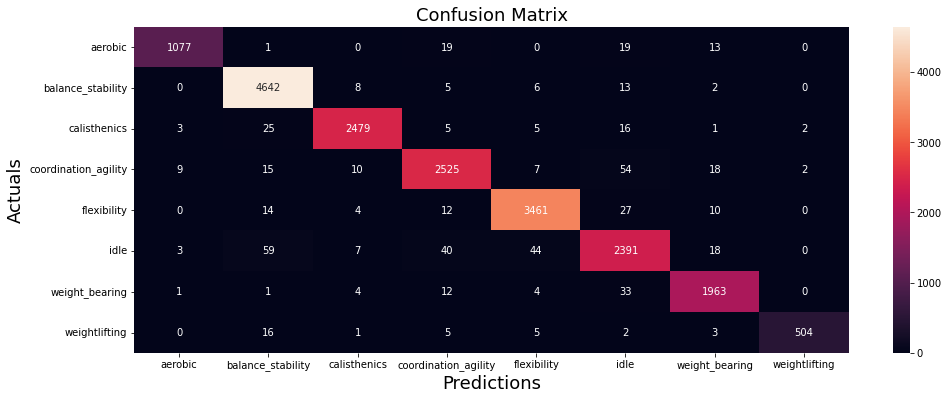

(array([4, 4, 4, ..., 0, 4, 3]),
 array([[0.        , 0.05      , 0.006     , ..., 0.        , 0.        ,
         0.004     ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.004     , 0.        , 0.012     , ..., 0.004     , 0.01      ,
         0.        ],
        ...,
        [0.5       , 0.        , 0.036     , ..., 0.12133333, 0.028     ,
         0.09      ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.026     , 0.02      , 0.068     , ..., 0.008     , 0.006     ,
         0.006     ]]),
 0.9702929936305732,
 0.9680354647971878,
 0.9702929936305732,
 0.9702929936305732,
 <function sklearn.metrics._classification.log_loss>)

In [ ]:
metrics(clf_extra,X_train, y_train, X_test, y_test,cf_matrix=True)

## SVM

In [ ]:
# Scaling 
from sklearn.preprocessing import StandardScaler
sc1 = StandardScaler()
X_scaled = sc1.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= config["train_test_split"] )

In [ ]:
from sklearn.svm import SVC
clf_svm = SVC(decision_function_shape='ovo', probability=True, random_state=config["random_state"])
clf_svm.fit(X_train,y_train)

SVC(decision_function_shape='ovo', probability=True, random_state=4)

ACCURACY PER INSTANCE: 0.830624203821656
F1_score: 0.8205319806153913
Precision: 0.830624203821656
Recall: 0.830624203821656
                      precision    recall  f1-score   support

             aerobic       0.82      0.72      0.77      1127
   balance_stability       0.80      0.93      0.86      4727
        calisthenics       0.90      0.83      0.86      2542
coordination_agility       0.81      0.79      0.80      2651
         flexibility       0.88      0.85      0.87      3485
                idle       0.75      0.75      0.75      2593
      weight_bearing       0.86      0.82      0.84      1945
       weightlifting       0.95      0.72      0.82       555

            accuracy                           0.83     19625
           macro avg       0.85      0.80      0.82     19625
        weighted avg       0.83      0.83      0.83     19625



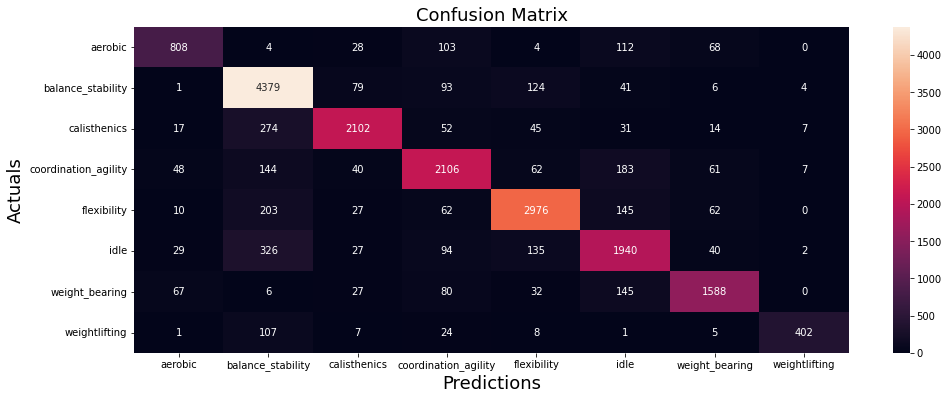

(array([4, 4, 4, ..., 7, 3, 5]),
 array([[1.27472051e-04, 4.20073002e-02, 1.11459447e-03, ...,
         3.32185619e-04, 1.00235030e-03, 2.80574616e-05],
        [2.75039648e-03, 1.11016082e-01, 2.63752467e-02, ...,
         2.19400146e-02, 2.99831228e-03, 3.63404487e-03],
        [1.37387782e-03, 1.31401488e-02, 1.09549988e-02, ...,
         5.51316329e-02, 1.08213301e-02, 5.28682542e-03],
        ...,
        [3.80511921e-04, 9.96114447e-03, 1.99282586e-03, ...,
         4.11442184e-02, 3.68838588e-04, 9.44107592e-01],
        [4.05037827e-03, 9.73414332e-05, 2.28371945e-02, ...,
         3.46090230e-04, 1.52561446e-04, 1.21343582e-04],
        [3.86910026e-04, 2.46923020e-01, 2.69896554e-02, ...,
         6.64868228e-01, 2.13588662e-03, 8.42991846e-04]]),
 0.830624203821656,
 0.8205319806153913,
 0.830624203821656,
 0.830624203821656,
 <function sklearn.metrics._classification.log_loss>)

In [ ]:
metrics(clf_svm,X_train, y_train, X_test, y_test,cf_matrix=True)

## Multilayer Perceptrons / Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(hidden_layer_sizes=(128,10), batch_size=100, random_state=config["random_state"])
clf_nn.fit(X_train,y_train)

MLPClassifier(batch_size=100, hidden_layer_sizes=(128, 10), random_state=4)

ACCURACY PER INSTANCE: 0.9071082802547771
F1_score: 0.8949473225915822
Precision: 0.9071082802547771
Recall: 0.9071082802547771
                      precision    recall  f1-score   support

             aerobic       0.87      0.84      0.85      1127
   balance_stability       0.94      0.93      0.94      4727
        calisthenics       0.93      0.93      0.93      2542
coordination_agility       0.90      0.89      0.90      2651
         flexibility       0.92      0.94      0.93      3485
                idle       0.85      0.84      0.84      2593
      weight_bearing       0.88      0.93      0.90      1945
       weightlifting       0.89      0.84      0.86       555

            accuracy                           0.91     19625
           macro avg       0.90      0.89      0.89     19625
        weighted avg       0.91      0.91      0.91     19625



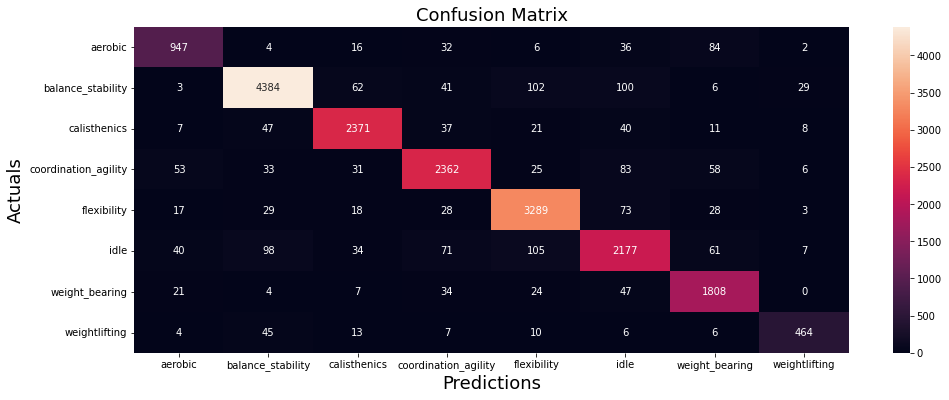

(array([4, 1, 4, ..., 7, 3, 5]),
 array([[3.92581904e-18, 1.12229473e-15, 3.38565217e-24, ...,
         1.44016147e-12, 1.03457656e-16, 2.36570810e-28],
        [1.13757483e-08, 7.55584478e-01, 2.45748879e-03, ...,
         1.36346057e-01, 1.87475035e-11, 3.52895047e-10],
        [8.02123176e-15, 2.03941212e-07, 7.03887035e-12, ...,
         1.25765637e-03, 1.33758338e-04, 3.43322135e-08],
        ...,
        [4.93079013e-18, 1.54477987e-03, 3.82363760e-06, ...,
         9.44369286e-02, 1.75204633e-07, 9.04014111e-01],
        [5.41136439e-19, 1.19350352e-34, 8.20055224e-09, ...,
         2.87219396e-16, 2.03732538e-18, 1.33468902e-26],
        [2.13470387e-11, 9.46042016e-02, 2.10314356e-02, ...,
         8.83214533e-01, 5.23620036e-11, 3.01987102e-10]], dtype=float32),
 0.9071082802547771,
 0.8949473225915822,
 0.9071082802547771,
 0.9071082802547771,
 <function sklearn.metrics._classification.log_loss>)

In [ ]:
metrics(clf_nn,X_train, y_train, X_test, y_test,cf_matrix=True)

## Some More Testing

Interpreting Permutation Importances:-
The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

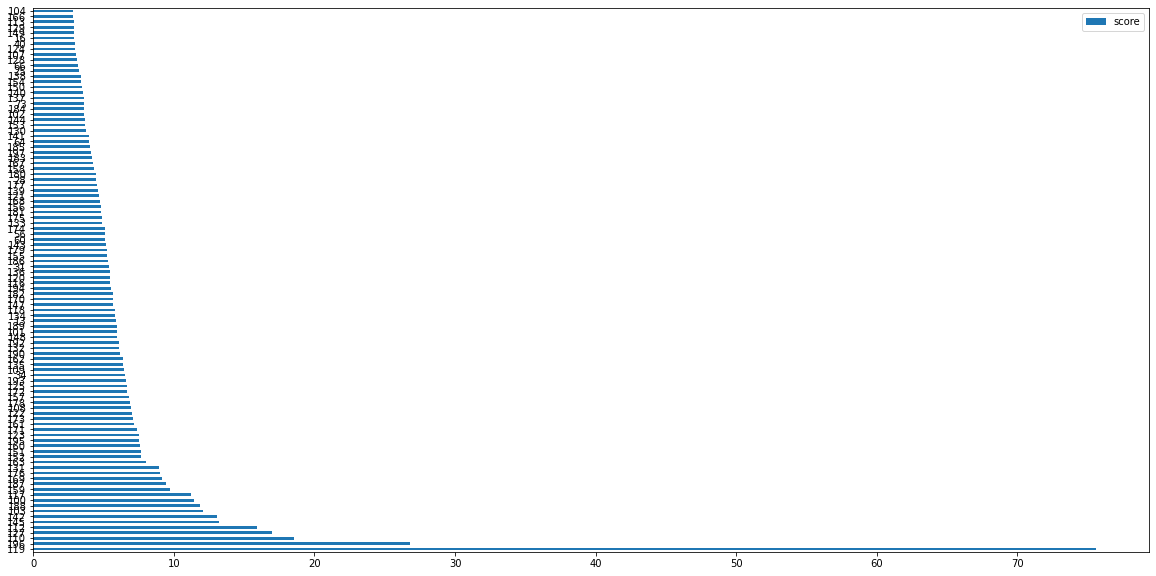

In [ ]:
feature_important = model.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

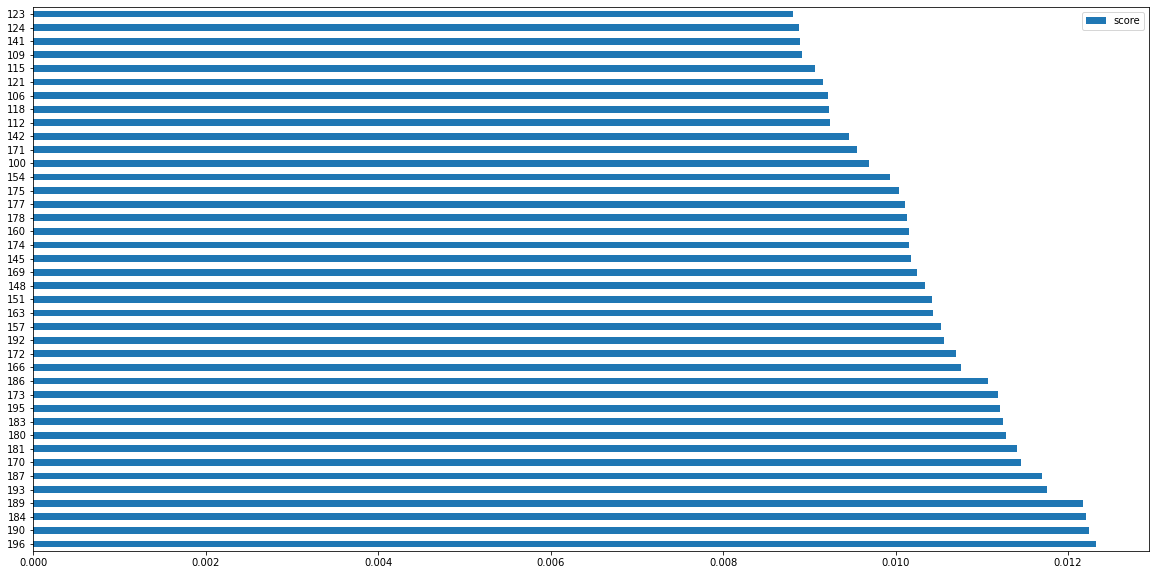

In [ ]:
importance = clf_extra.feature_importances_
from matplotlib import pyplot
keys = []
values = []
# summarize feature importance
for i,v in enumerate(importance):
  keys.append(i)
  values.append(v)
# plot feature importance


data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features